<a href="https://colab.research.google.com/github/FeliGR/Madrid-Mortality-Forecast-Climate-Time-Series/blob/main/madrid_mortality_forecast_with_climate_exogenous_variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!pip install skforecast
!pip install xgboost


## **Carga y Preparación de los Datos**
A continuación, cargamos los datos y verificamos la estructura, tipos de datos, y la existencia de valores faltantes.

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

In [26]:
defunciones_temperaturas_madrid_df = pd.read_csv('defunciones_temperaturas_madrid.csv')

In [27]:
print(defunciones_temperaturas_madrid_df.head())

        fecha  defunciones_corregidas  tavg  tmin  tmax
0  2015-01-01                  148.74   5.9  -1.0  10.4
1  2015-01-02                  159.11   7.6  -1.0  12.0
2  2015-01-03                  161.42   7.7   1.2  11.4
3  2015-01-04                  140.67  10.1   1.4  14.0
4  2015-01-05                  181.02   7.7   1.5  12.0


In [28]:
print(defunciones_temperaturas_madrid_df.dtypes)

fecha                      object
defunciones_corregidas    float64
tavg                      float64
tmin                      float64
tmax                      float64
dtype: object


In [29]:
defunciones_temperaturas_madrid_df['fecha'] = pd.to_datetime(defunciones_temperaturas_madrid_df['fecha'], errors='coerce')
defunciones_temperaturas_madrid_df.set_index('fecha', inplace=True)
defunciones_temperaturas_madrid_df = defunciones_temperaturas_madrid_df.asfreq('D')

In [30]:
print(defunciones_temperaturas_madrid_df.head())

            defunciones_corregidas  tavg  tmin  tmax
fecha                                               
2015-01-01                  148.74   5.9  -1.0  10.4
2015-01-02                  159.11   7.6  -1.0  12.0
2015-01-03                  161.42   7.7   1.2  11.4
2015-01-04                  140.67  10.1   1.4  14.0
2015-01-05                  181.02   7.7   1.5  12.0


In [31]:
print(defunciones_temperaturas_madrid_df.describe())

       defunciones_corregidas         tavg         tmin         tmax
count             3531.000000  3531.000000  3531.000000  3531.000000
mean               136.880949    16.257293    11.229708    21.464514
std                 51.089576     8.056835     6.769917     9.105693
min                 68.030000    -3.200000    -7.400000     0.300000
25%                116.450000     9.500000     5.600000    13.500000
50%                130.020000    15.100000    10.500000    20.300000
75%                146.270000    22.800000    16.700000    29.000000
max                817.270000    34.400000    26.200000    40.700000


In [32]:
print(defunciones_temperaturas_madrid_df.isnull().sum())

defunciones_corregidas    0
tavg                      0
tmin                      0
tmax                      0
dtype: int64


---

## **Análisis Exploratorio de la Serie Temporal (Sin Variables Exógenas)**
En esta sección, se realiza la descomposición de la serie temporal de defunciones. Además, se calculan las funciones de autocorrelación y autocorrelación parcial, y se visualiza la media móvil de las defunciones.

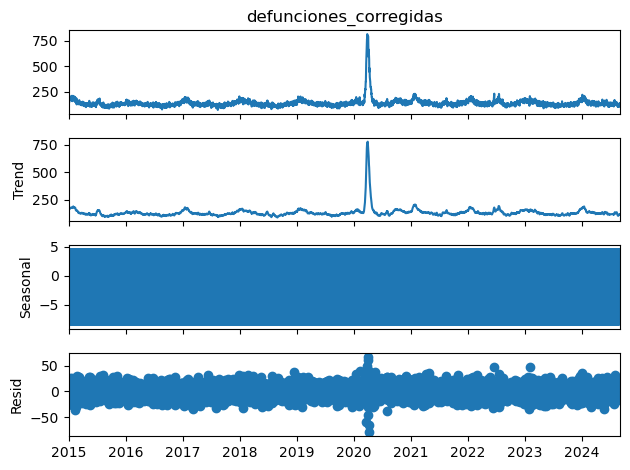

In [33]:
decomposed_defunciones_sin_exogenas = sm.tsa.seasonal_decompose(defunciones_temperaturas_madrid_df['defunciones_corregidas'], model='additive')
decomposed_defunciones_sin_exogenas.plot()
plt.show()

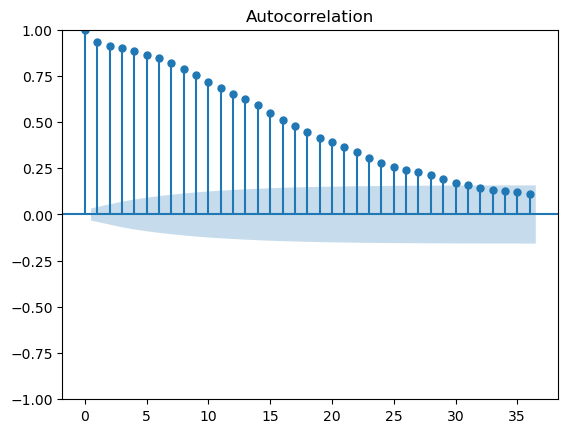

In [34]:
plot_acf(defunciones_temperaturas_madrid_df['defunciones_corregidas'])
plt.show()

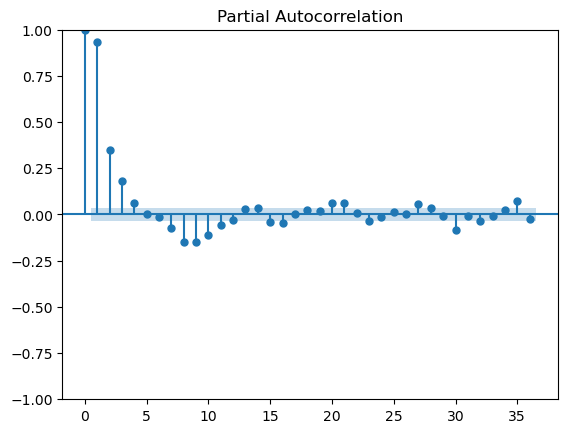

In [35]:
plot_pacf(defunciones_temperaturas_madrid_df['defunciones_corregidas'])
plt.show()

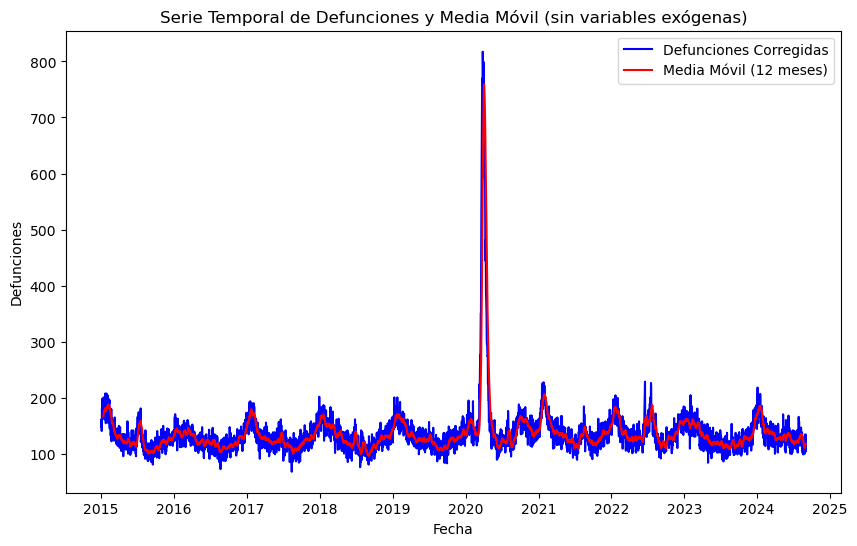

In [36]:
defunciones_temperaturas_madrid_df['defunciones_rolling'] = defunciones_temperaturas_madrid_df['defunciones_corregidas'].rolling(window=12).mean()

plt.figure(figsize=(10, 6))
plt.plot(defunciones_temperaturas_madrid_df.index, defunciones_temperaturas_madrid_df['defunciones_corregidas'], label='Defunciones Corregidas', color='blue')
plt.plot(defunciones_temperaturas_madrid_df.index, defunciones_temperaturas_madrid_df['defunciones_rolling'], label='Media Móvil (12 meses)', color='red')
plt.title('Serie Temporal de Defunciones y Media Móvil (sin variables exógenas)')
plt.xlabel('Fecha')
plt.ylabel('Defunciones')
plt.legend()
plt.show()

---

## **Análisis Exploratorio de la Serie Temporal (Con Variables Exógenas)**
A continuación, se grafican las variables exógenas (temperaturas) y se calculan las autocorrelaciones y las correlaciones entre las variables.

In [37]:
plt.figure(figsize=(14, 7))

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

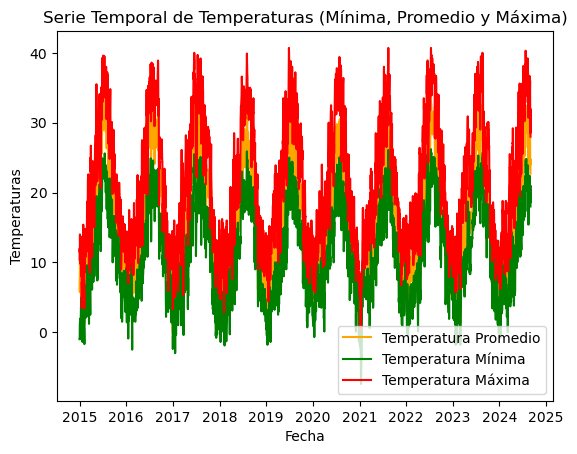

In [38]:
plt.plot(defunciones_temperaturas_madrid_df.index, defunciones_temperaturas_madrid_df['tavg'], color='orange', label='Temperatura Promedio')
plt.plot(defunciones_temperaturas_madrid_df.index, defunciones_temperaturas_madrid_df['tmin'], color='green', label='Temperatura Mínima')
plt.plot(defunciones_temperaturas_madrid_df.index, defunciones_temperaturas_madrid_df['tmax'], color='red', label='Temperatura Máxima')

plt.title('Serie Temporal de Temperaturas (Mínima, Promedio y Máxima)')
plt.xlabel('Fecha')
plt.ylabel('Temperaturas')
plt.legend()
plt.show()

<Figure size 1000x600 with 0 Axes>

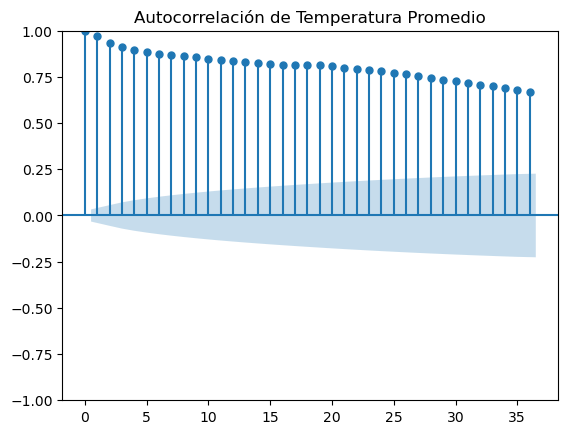

In [39]:
plt.figure(figsize=(10, 6))
plot_acf(defunciones_temperaturas_madrid_df['tavg'], title='Autocorrelación de Temperatura Promedio')
plt.show()

<Figure size 1000x600 with 0 Axes>

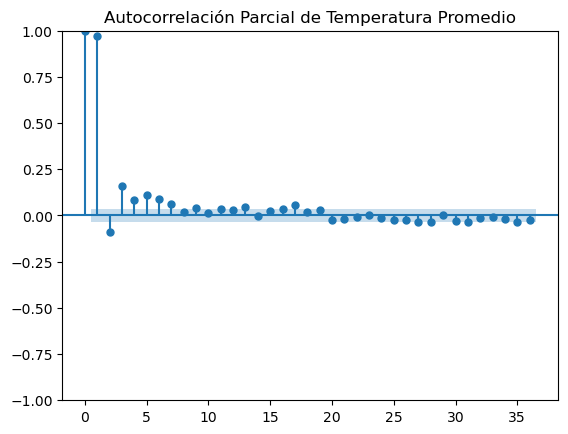

In [40]:
plt.figure(figsize=(10, 6))
plot_pacf(defunciones_temperaturas_madrid_df['tavg'], title='Autocorrelación Parcial de Temperatura Promedio')
plt.show()

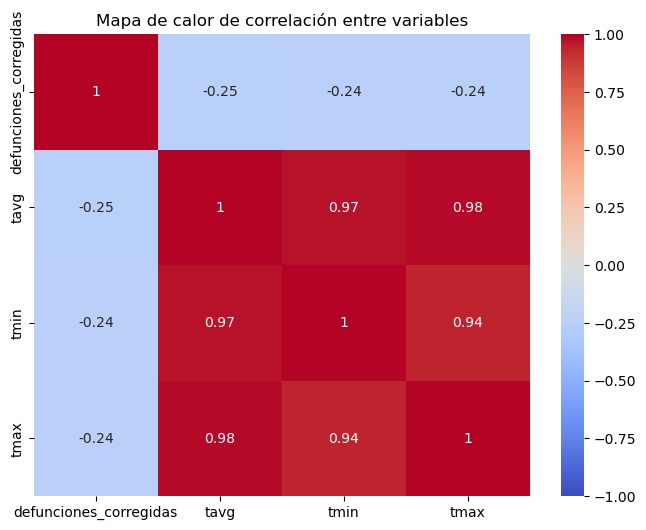

In [41]:
correlation_matrix = defunciones_temperaturas_madrid_df[['defunciones_corregidas', 'tavg', 'tmin', 'tmax']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa de calor de correlación entre variables')
plt.show()

---

## **Separación de Datos en Entrenamiento y Prueba (Sin Variables Exógenas)**
Dividimos los datos de **defunciones corregidas** en un 80% para el conjunto de **entrenamiento** y un 20% para el conjunto de **prueba** usando `train_test_split` de **sklearn**. No se utilizan variables exógenas en este paso, lo que significa que el modelo solo utilizará la serie de defunciones para hacer predicciones.

In [42]:
exog_variables = defunciones_temperaturas_madrid_df[['tavg', 'tmin', 'tmax']].resample('W').mean()
defunciones_semanales_df = defunciones_temperaturas_madrid_df['defunciones_corregidas'].resample('W').sum()

y_train, y_test = train_test_split(defunciones_semanales_df, test_size=0.1, shuffle=False)
exog_train, exog_test = train_test_split(exog_variables, test_size=0.1, shuffle=False)

print(f"Fechas de entrenamiento (y_train): {y_train.index.min()} --- {y_train.index.max()}")
print(f"Fechas de entrenamiento (exog_train): {exog_train.index.min()} --- {exog_train.index.max()}")
print(f"Fechas de prueba (y_test): {y_test.index.min()} --- {y_test.index.max()}")
print(f"Fechas de prueba (exog_test): {exog_test.index.min()} --- {exog_test.index.max()}")


Fechas de entrenamiento (y_train): 2015-01-04 00:00:00 --- 2023-09-10 00:00:00
Fechas de entrenamiento (exog_train): 2015-01-04 00:00:00 --- 2023-09-10 00:00:00
Fechas de prueba (y_test): 2023-09-17 00:00:00 --- 2024-09-01 00:00:00
Fechas de prueba (exog_test): 2023-09-17 00:00:00 --- 2024-09-01 00:00:00


---

# **ForecasterAutoreg con RandomForestRegressor (Sin variables exógenas)**

Error cuadrático medio: 10197.90034228432


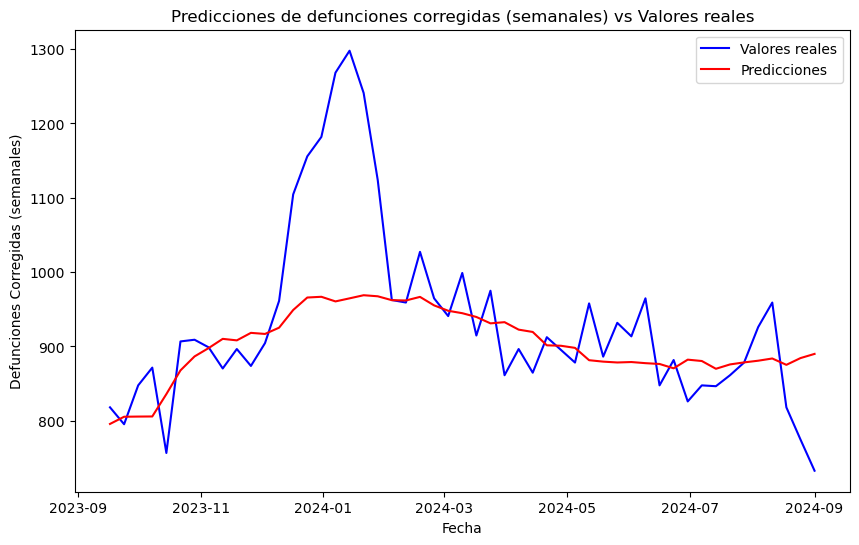

In [43]:

forecaster = ForecasterAutoreg(
    regressor = RandomForestRegressor(n_estimators=100, random_state=42),
    lags = 100
)

forecaster.fit(y_train)

y_pred = forecaster.predict(steps=len(y_test))

error_mse = mean_squared_error(y_test, y_pred)
print(f'Error cuadrático medio: {error_mse}')

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Valores reales', color='blue')
plt.plot(y_test.index, y_pred, label='Predicciones', color='red')
plt.title('Predicciones de defunciones corregidas (semanales) vs Valores reales')
plt.xlabel('Fecha')
plt.ylabel('Defunciones Corregidas (semanales)')
plt.legend()
plt.show()


# **ForecasterAutoreg con RandomForestRegressor (Con variables exógenas)**

Error cuadrático medio con variables exógenas: 6453.555084367662


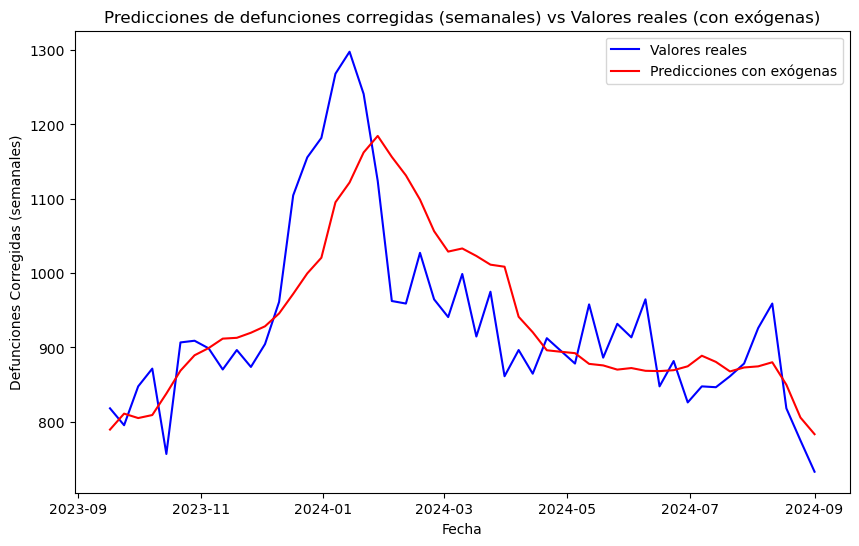

In [44]:
forecaster = ForecasterAutoreg(
    regressor = RandomForestRegressor(n_estimators=100, random_state=42),
    lags = 100
)

forecaster.fit(y=y_train, exog=exog_train)

y_pred = forecaster.predict(steps=len(y_test), exog=exog_test)

error_mse = mean_squared_error(y_test, y_pred)
print(f'Error cuadrático medio con variables exógenas: {error_mse}')

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Valores reales', color='blue')
plt.plot(y_test.index, y_pred, label='Predicciones con exógenas', color='red')
plt.title('Predicciones de defunciones corregidas (semanales) vs Valores reales (con exógenas)')
plt.xlabel('Fecha')
plt.ylabel('Defunciones Corregidas (semanales)')
plt.legend()
plt.show()

---

# **ForecasterAutoreg con GradientBoostingRegressor (Sin variables exógenas)**

Error cuadrático medio sin variables exógenas: 14066.574111270495


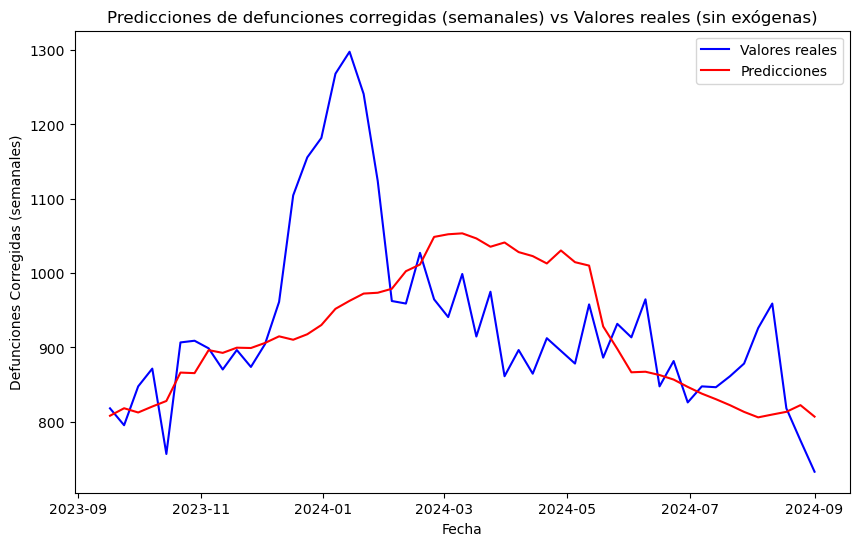

In [45]:
forecaster_sin_exog = ForecasterAutoreg(
    regressor = GradientBoostingRegressor(n_estimators=100, random_state=42),
    lags = 100
)

forecaster_sin_exog.fit(y=y_train)

y_pred_sin_exog = forecaster_sin_exog.predict(steps=len(y_test))

error_mse_sin_exog = mean_squared_error(y_test, y_pred_sin_exog)
print(f'Error cuadrático medio sin variables exógenas: {error_mse_sin_exog}')

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Valores reales', color='blue')
plt.plot(y_test.index, y_pred_sin_exog, label='Predicciones', color='red')
plt.title('Predicciones de defunciones corregidas (semanales) vs Valores reales (sin exógenas)')
plt.xlabel('Fecha')
plt.ylabel('Defunciones Corregidas (semanales)')
plt.legend()
plt.show()


# **ForecasterAutoreg con GradientBoostingRegressor (Con variables exógenas)**

Error cuadrático medio con variables exógenas: 8952.855573539015


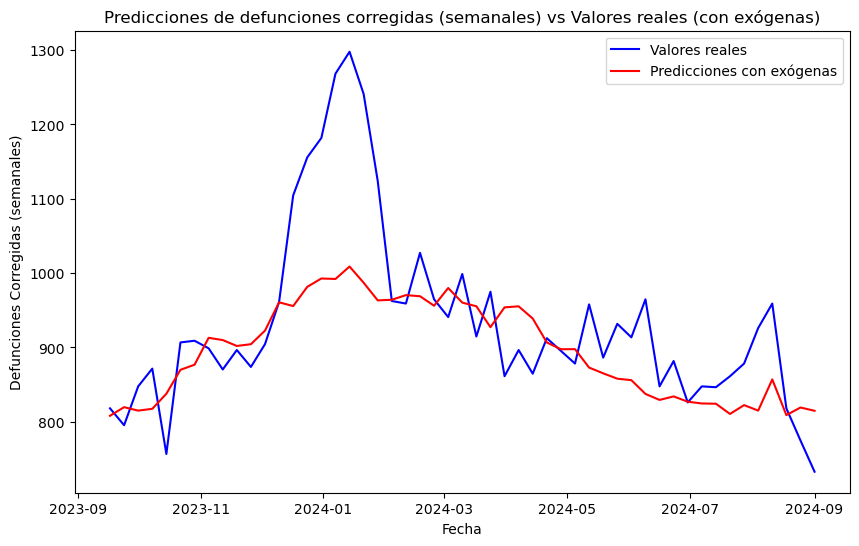

In [46]:
forecaster_con_exog = ForecasterAutoreg(
    regressor = GradientBoostingRegressor(n_estimators=100, random_state=42),
    lags = 100
)

forecaster_con_exog.fit(y=y_train, exog=exog_train)

y_pred_con_exog = forecaster_con_exog.predict(steps=len(y_test), exog=exog_test)

error_mse_con_exog = mean_squared_error(y_test, y_pred_con_exog)
print(f'Error cuadrático medio con variables exógenas: {error_mse_con_exog}')

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Valores reales', color='blue')
plt.plot(y_test.index, y_pred_con_exog, label='Predicciones con exógenas', color='red')
plt.title('Predicciones de defunciones corregidas (semanales) vs Valores reales (con exógenas)')
plt.xlabel('Fecha')
plt.ylabel('Defunciones Corregidas (semanales)')
plt.legend()
plt.show()

---

# **ForecasterAutoreg con XGBoost (Sin variables exógenas)**

Error cuadrático medio sin variables exógenas: 10915.934136808733


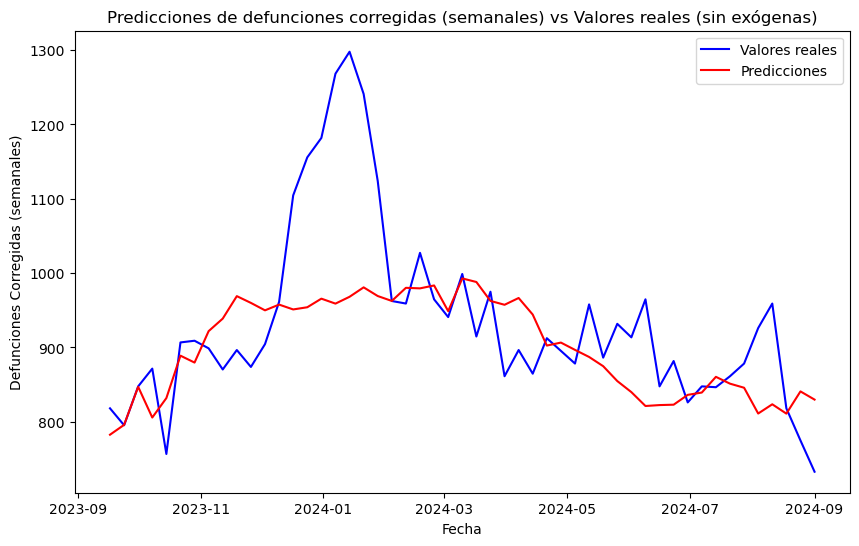

In [47]:
forecaster_sin_exog = ForecasterAutoreg(
    regressor = XGBRegressor(n_estimators=100, random_state=42),
    lags = 100  # Ajusta el número de lags según sea necesario
)

forecaster_sin_exog.fit(y=y_train)

y_pred_sin_exog = forecaster_sin_exog.predict(steps=len(y_test))

error_mse_sin_exog = mean_squared_error(y_test, y_pred_sin_exog)
print(f'Error cuadrático medio sin variables exógenas: {error_mse_sin_exog}')

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Valores reales', color='blue')
plt.plot(y_test.index, y_pred_sin_exog, label='Predicciones', color='red')
plt.title('Predicciones de defunciones corregidas (semanales) vs Valores reales (sin exógenas)')
plt.xlabel('Fecha')
plt.ylabel('Defunciones Corregidas (semanales)')
plt.legend()
plt.show()


# **ForecasterAutoreg con XGBoost (Con variables exógenas)**

Error cuadrático medio con variables exógenas: 8822.702088053209


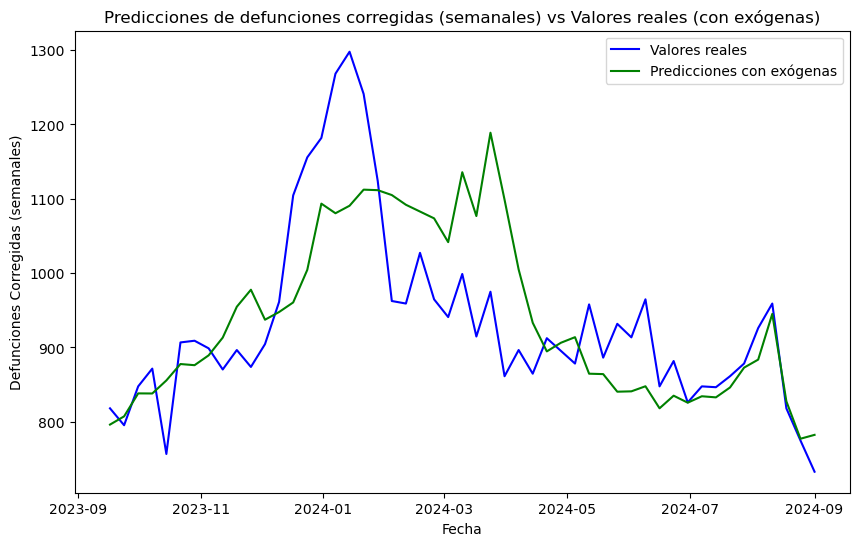

In [48]:
forecaster_con_exog = ForecasterAutoreg(
    regressor = XGBRegressor(n_estimators=100, random_state=42),
    lags = 100  # Ajusta el número de lags según sea necesario
)

forecaster_con_exog.fit(y=y_train, exog=exog_train)

y_pred_con_exog = forecaster_con_exog.predict(steps=len(y_test), exog=exog_test)

error_mse_con_exog = mean_squared_error(y_test, y_pred_con_exog)
print(f'Error cuadrático medio con variables exógenas: {error_mse_con_exog}')

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Valores reales', color='blue')
plt.plot(y_test.index, y_pred_con_exog, label='Predicciones con exógenas', color='green')
plt.title('Predicciones de defunciones corregidas (semanales) vs Valores reales (con exógenas)')
plt.xlabel('Fecha')
plt.ylabel('Defunciones Corregidas (semanales)')
plt.legend()
plt.show()

---

# **ForecasterAutoreg con ElasticNet (Sin variables exógenas)**

Error cuadrático medio sin variables exógenas: 13454.081788557083


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.610e+05, tolerance: 5.603e+03
  model = cd_fast.enet_coordinate_descent(


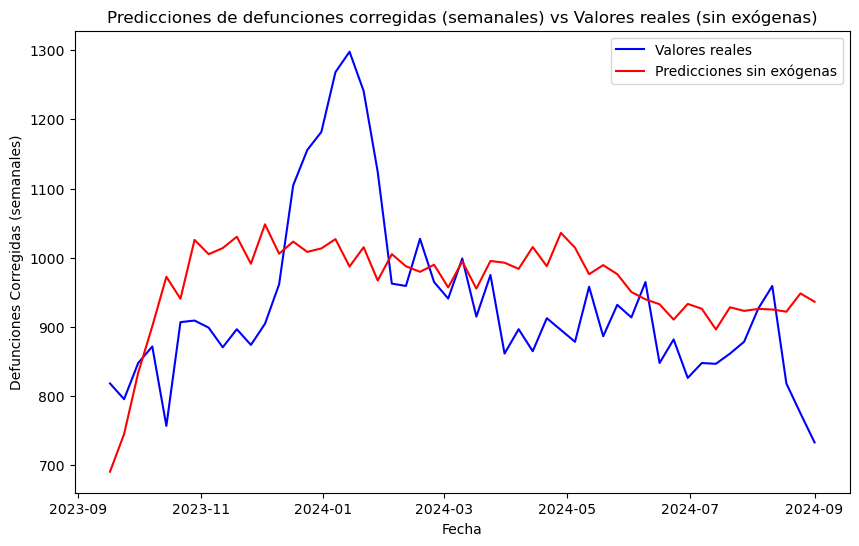

In [49]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

forecaster_sin_exog = ForecasterAutoreg(
    regressor = ElasticNet(alpha=0.1, l1_ratio=0.5),
    lags = 100
)

forecaster_sin_exog.fit(y=y_train)

y_pred_sin_exog = forecaster_sin_exog.predict(steps=len(y_test))

error_mse_sin_exog = mean_squared_error(y_test, y_pred_sin_exog)
print(f'Error cuadrático medio sin variables exógenas: {error_mse_sin_exog}')

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Valores reales', color='blue')
plt.plot(y_test.index, y_pred_sin_exog, label='Predicciones sin exógenas', color='red')
plt.title('Predicciones de defunciones corregidas (semanales) vs Valores reales (sin exógenas)')
plt.xlabel('Fecha')
plt.ylabel('Defunciones Corregidas (semanales)')
plt.legend()
plt.show()

# **ForecasterAutoreg con ElasticNet (Con variables exógenas)**

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.450e+05, tolerance: 5.603e+03
  model = cd_fast.enet_coordinate_descent(


Error cuadrático medio con variables exógenas: 11872.920957714081


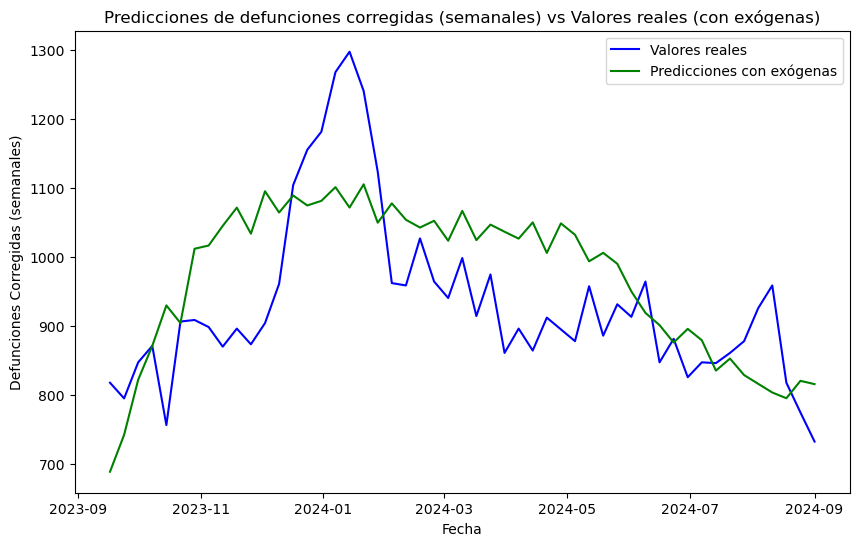

In [50]:
forecaster_con_exog = ForecasterAutoreg(
    regressor = ElasticNet(alpha=0.1, l1_ratio=0.5),
    lags = 100
)

forecaster_con_exog.fit(y=y_train, exog=exog_train)

y_pred_con_exog = forecaster_con_exog.predict(steps=len(y_test), exog=exog_test)

error_mse_con_exog = mean_squared_error(y_test, y_pred_con_exog)
print(f'Error cuadrático medio con variables exógenas: {error_mse_con_exog}')

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Valores reales', color='blue')
plt.plot(y_test.index, y_pred_con_exog, label='Predicciones con exógenas', color='green')
plt.title('Predicciones de defunciones corregidas (semanales) vs Valores reales (con exógenas)')
plt.xlabel('Fecha')
plt.ylabel('Defunciones Corregidas (semanales)')
plt.legend()
plt.show()


---

# **ForecasterAutoreg con DecisionTreeRegressor (Sin variables exógenas)**

Error cuadrático medio sin variables exógenas: 8746.116702836998


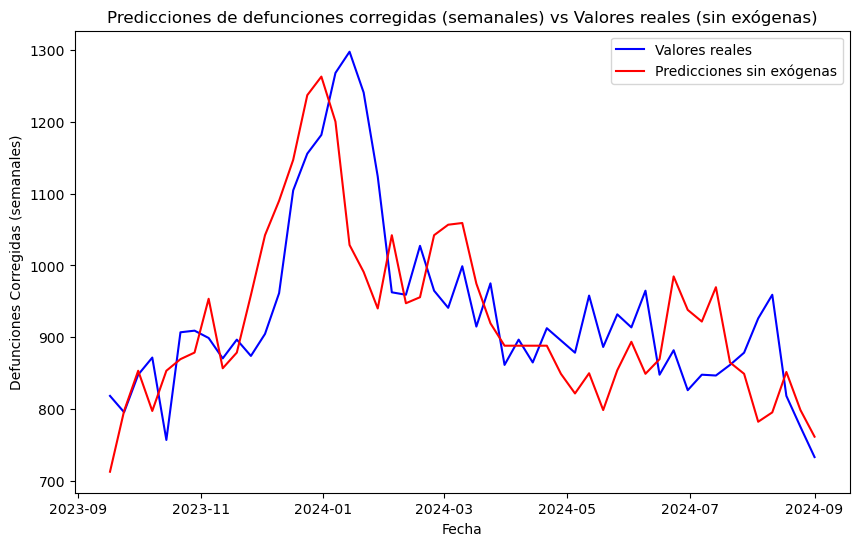

In [51]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg

forecaster_sin_exog = ForecasterAutoreg(
    regressor = DecisionTreeRegressor(max_depth=10, random_state=42),
    lags = 60
)

forecaster_sin_exog.fit(y=y_train)

y_pred_sin_exog = forecaster_sin_exog.predict(steps=len(y_test))

error_mse_sin_exog = mean_squared_error(y_test, y_pred_sin_exog)
print(f'Error cuadrático medio sin variables exógenas: {error_mse_sin_exog}')

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Valores reales', color='blue')
plt.plot(y_test.index, y_pred_sin_exog, label='Predicciones sin exógenas', color='red')
plt.title('Predicciones de defunciones corregidas (semanales) vs Valores reales (sin exógenas)')
plt.xlabel('Fecha')
plt.ylabel('Defunciones Corregidas (semanales)')
plt.legend()
plt.show()


# **ForecasterAutoreg con DecisionTreeRegressor (Con variables exógenas)**

Error cuadrático medio con variables exógenas: 6114.180544854248


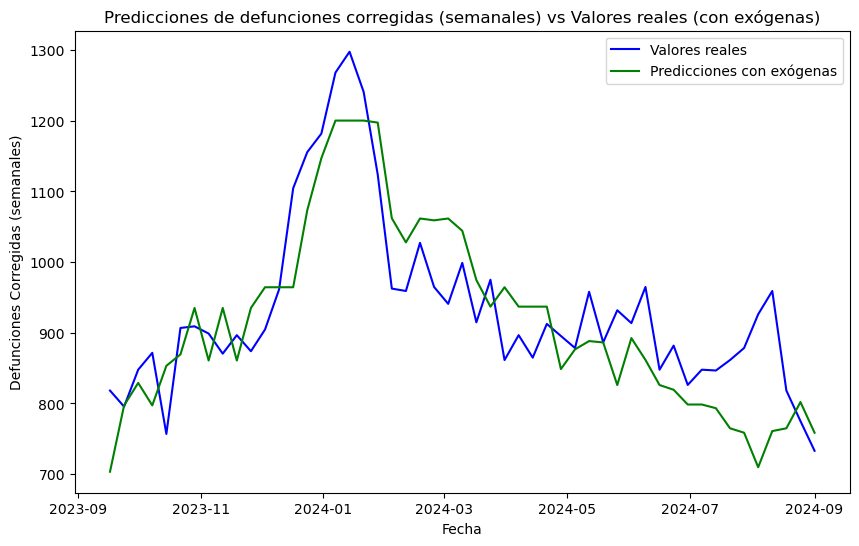

In [52]:
forecaster_con_exog = ForecasterAutoreg(
    regressor = DecisionTreeRegressor(max_depth=10, random_state=42),
    lags = 60
)

forecaster_con_exog.fit(y=y_train, exog=exog_train)

y_pred_con_exog = forecaster_con_exog.predict(steps=len(y_test), exog=exog_test)

error_mse_con_exog = mean_squared_error(y_test, y_pred_con_exog)
print(f'Error cuadrático medio con variables exógenas: {error_mse_con_exog}')

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Valores reales', color='blue')
plt.plot(y_test.index, y_pred_con_exog, label='Predicciones con exógenas', color='green')
plt.title('Predicciones de defunciones corregidas (semanales) vs Valores reales (con exógenas)')
plt.xlabel('Fecha')
plt.ylabel('Defunciones Corregidas (semanales)')
plt.legend()
plt.show()


---

# **ForecasterAutoreg con KNeighborsRegressor (Con variables exógenas)**

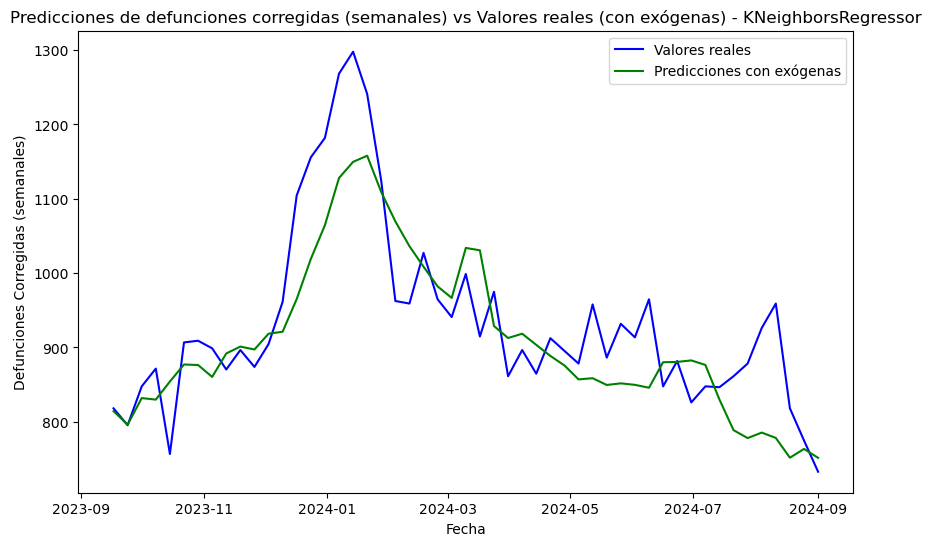

In [53]:
# Crear el modelo ForecasterAutoreg con KNeighborsRegressor (con variables exógenas)
forecaster_con_exog = ForecasterAutoreg(
    regressor = KNeighborsRegressor(n_neighbors=8),  # Ajusta el número de vecinos según sea necesario
    lags = 40 # Ajusta el número de lags según sea necesario
)

forecaster_con_exog.fit(y=y_train, exog=exog_train)

y_pred_con_exog = forecaster_con_exog.predict(steps=len(y_test), exog=exog_test)

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Valores reales', color='blue')
plt.plot(y_test.index, y_pred_con_exog, label='Predicciones con exógenas', color='green')
plt.title('Predicciones de defunciones corregidas (semanales) vs Valores reales (con exógenas) - KNeighborsRegressor')
plt.xlabel('Fecha')
plt.ylabel('Defunciones Corregidas (semanales)')
plt.legend()
plt.show()


# **GridSearch para ForecasterAutoreg con KNeighborsRegressor (Con Variables Exógenas)**

Number of models compared: 2304.


lags grid:   0%|          | 0/12 [00:00<?, ?it/s]

params grid:   0%|          | 0/192 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] 
  Parameters: {'algorithm': 'kd_tree', 'metric': 'minkowski', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
  Backtesting metric: 5169.494705928325



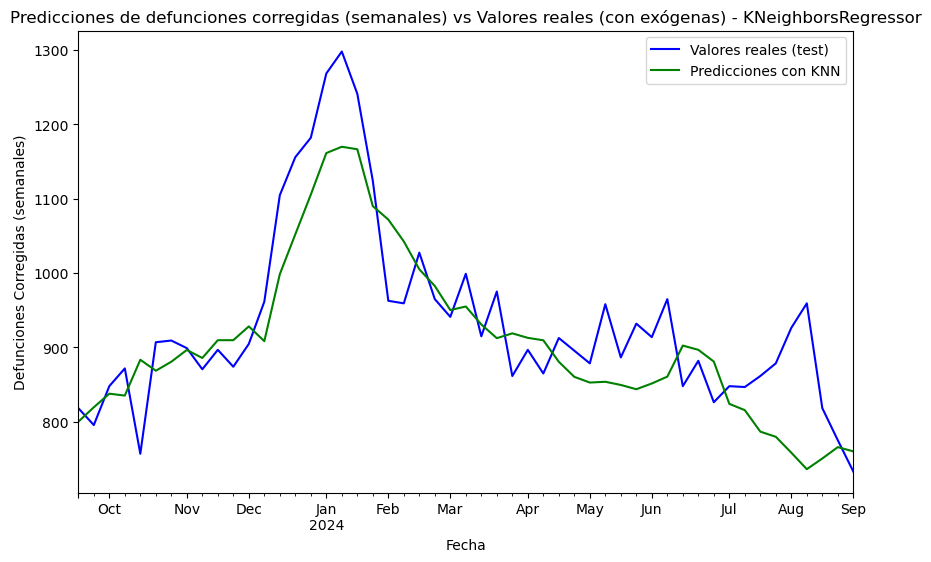

In [54]:
from skforecast.model_selection import grid_search_forecaster
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

forecaster = ForecasterAutoreg(
    regressor = KNeighborsRegressor(),
    lags = 40
)

param_grid = {
    'n_neighbors': [5, 30, 40, 50], 
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean', 'manhattan'],
    'p': [2, 1],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

lags_grid = [20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130]

resultados_grid = grid_search_forecaster(
    forecaster         = forecaster,
    y                  = defunciones_semanales_df,
    exog               = exog_variables,
    param_grid         = param_grid,
    lags_grid          = lags_grid,
    steps              = len(y_test),
    refit              = True,
    metric             = 'mean_squared_error',
    initial_train_size = int(len(defunciones_semanales_df) * 0.9),
    fixed_train_size   = False,
    return_best        = True,
    verbose            = False
)

forecaster = ForecasterAutoreg(
    regressor = KNeighborsRegressor(
        algorithm='auto', 
        metric='manhattan', 
        n_neighbors=5, 
        p=2, 
        weights='distance'
    ),
    lags=40
)

forecaster.fit(y=y_train, exog=exog_train)

predicciones_knn = forecaster.predict(steps=len(y_test), exog=exog_test)

plt.figure(figsize=(10, 6))
y_test.plot(label='Valores reales (test)', color='blue')
predicciones_knn.plot(label='Predicciones con KNN', color='green')
plt.title('Predicciones de defunciones corregidas (semanales) vs Valores reales (con exógenas) - KNeighborsRegressor')
plt.xlabel('Fecha')
plt.ylabel('Defunciones Corregidas (semanales)')
plt.legend()
plt.show()


---